# Social Networks Final Project: Protein-Protein Interactions (PPI)

**Group members:**

Marina Iuliana Aur, *1809715* <br>
Cristiana Di Tullio, *1803880*

## Import libraries and dependencies

In [50]:
# Run if needed
#%pip install torch-geometric
#%pip install markov-clustering

In [113]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import itertools
import pprint
import torch
from torch.cuda import is_available
from torch_geometric.utils import to_networkx, negative_sampling
import markov_clustering as mc
from scipy.sparse import csr_matrix

In [52]:
# CPU/GPU
device = 'cpu'
if torch.cuda.is_available():
	device = 'gpu'

print(f'Using device {device}')

Using device cpu


## Utility functions

In [53]:
# Graph visualization functions from the SNOM Lab
# NOTE: the original input object was not a normal networkx graph
def convert_to_networkx(graph):
	g = to_networkx(graph, node_attrs = ['x'])
	y = graph.y.numpy()
	return g, y

def plot_graph(g, y):
	plt.figure(figsize = (9, 7))
	nx.draw_spring(g, node_size = 30, arrows = False, node_color = y)
	plt.show()

In [54]:
def print_dict(string, dictionary, n = 5):
    """
    Utility function to display only the first n elements
    of a dictionary.
    """
    dictionary = dict(dictionary)

    out = dict(itertools.islice(dictionary.items(), n))
    print(string)
    print("-" * len(string))
    pprint.pprint(out)
    print("")

## 1) Introduction


 ### 1.1) Dataset description

**(Da rivedere/sistemare/aggiungere)**  

We downloaded human protein-protein interaction (PPI) data from **BioGRID 4.4.236 CORONAVIRUS** [[¹]](https://downloads.thebiogrid.org/File/BioGRID/Release-Archive/BIOGRID-4.4.236/BIOGRID-CORONAVIRUS-4.4.236.tab3.zip) dataset. In response to the COVID-19 pandemic, intensive efforts by the international research community have generated a vast amount of new data on Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2), the causal agent of COVID-19. This includes data on related coronaviruses such as SARS-CoV and MERS-CoV, which cause Severe Acute Respiratory Syndrome (SARS) and Middle East Respiratory Syndrome (MERS), respectively.

Each row in the dataset represents a unique interaction between two proteins, allowing us to better understand the biology of the pathogen and facilitating the development of new therapeutic approaches. Specifically, the dataset includes information on all direct interactions between virally-encoded proteins and host cell proteins, as well as post-translational modifications and chemical interactions of viral proteins [[²]](https://thebiogrid.org/project/3/covid-19-coronavirus.html).


In [114]:
# Load PPI dataset
#covid_df = pd.read_csv('BIOGRID-CORONAVIRUS-4.4.236.tab3.txt', sep = '\t')
covid_df = pd.read_csv('BIOGRID-PROJECT-covid19_coronavirus_project-INTERACTIONS-4.4.237.tab3.txt', sep = '\t')
covid_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,GU280_gp04,-,E,AP3B1,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001258698|NP_003655,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,GU280_gp04,-,E,BRD4,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001317313|NP_490597|NP_001366221|NP_0013662...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,GU280_gp04,DADB-17J1.3,E,BRD2,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,X5CF57|A0A024RCR5,NP_001186384|NP_005095|NP_001278915|NP_0011066...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,GU280_gp04,UNQ438/PRO871,E,CWC27,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,D6REK3,NP_001284574|NP_005860|NP_001351407|NP_0013049...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,GU280_gp04,-,E,ZC3H18,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,B4DTK7|E7ERS3,NP_653205|NP_001281269,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens


In [104]:
# Features overview
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44805 entries, 0 to 44804
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   #BioGRID Interaction ID             44805 non-null  int64 
 1   Entrez Gene Interactor A            44805 non-null  object
 2   Entrez Gene Interactor B            44805 non-null  object
 3   BioGRID ID Interactor A             44805 non-null  int64 
 4   BioGRID ID Interactor B             44805 non-null  int64 
 5   Systematic Name Interactor A        44805 non-null  object
 6   Systematic Name Interactor B        44805 non-null  object
 7   Official Symbol Interactor A        44805 non-null  object
 8   Official Symbol Interactor B        44805 non-null  object
 9   Synonyms Interactor A               44805 non-null  object
 10  Synonyms Interactor B               44805 non-null  object
 11  Experimental System                 44805 non-null  ob

In [105]:
# Missing values
covid_df.isna().sum()

#BioGRID Interaction ID                0
Entrez Gene Interactor A               0
Entrez Gene Interactor B               0
BioGRID ID Interactor A                0
BioGRID ID Interactor B                0
Systematic Name Interactor A           0
Systematic Name Interactor B           0
Official Symbol Interactor A           0
Official Symbol Interactor B           0
Synonyms Interactor A                  0
Synonyms Interactor B                  0
Experimental System                    0
Experimental System Type               0
Author                                 0
Publication Source                     0
Organism ID Interactor A               0
Organism ID Interactor B               0
Throughput                             0
Score                                  0
Modification                           0
Qualifications                         0
Tags                                   0
Source Database                        0
SWISS-PROT Accessions Interactor A     0
TREMBL Accession

In [115]:
# Handling missing values
covid_df.dropna(inplace = True)

In [107]:
### Exploring interactions ###

organism_a_counts = covid_df['Organism Name Interactor A'].value_counts().reset_index()
organism_a_counts.columns = ['Organism', 'Count']

organism_b_counts = covid_df['Organism Name Interactor B'].value_counts().reset_index()
organism_b_counts.columns = ['Organism', 'Count']

num_colors_a = len(organism_a_counts)
num_colors_b = len(organism_b_counts)
colors_a = pc.sample_colorscale('Viridis', [n/(num_colors_a-1) for n in range(num_colors_a)])
colors_b = pc.sample_colorscale('Viridis', [n/(num_colors_b-1) for n in range(num_colors_b)])

# Plot
fig = make_subplots(rows = 2, cols = 1, subplot_titles = ('Organism Name Interactor A', 
                                                          'Organism Name Interactor B'), vertical_spacing = 0.4)

fig.add_trace(go.Bar(x = organism_a_counts['Organism'], 
                     y = organism_a_counts['Count'],
                     orientation = 'v',
                     marker = dict(color = colors_a), 
                     showlegend = False),
              row = 1, col = 1)

fig.add_trace(go.Bar(x = organism_b_counts['Organism'], 
                     y = organism_b_counts['Count'],
                     orientation = 'v',
                     marker = dict(color = colors_b),
                     showlegend = False),
              row = 2, col = 1)

fig.update_yaxes(type = 'log', title_text = "count (log scale)", row = 1, col = 1)
fig.update_yaxes(type = 'log', title_text = "count (log scale)", row = 2, col = 1)
fig.update_xaxes(title_text = "organism", row = 1, col = 1)
fig.update_xaxes(title_text = "organism", row = 2, col = 1)
fig.update_layout(height = 1000,
                  title_text = "Distribution of Organism Name Interactor A e B", 
                  showlegend = False)

fig.show()

In [116]:
### Exploring interactors ###

interactor_a = covid_df[['BioGRID ID Interactor A', 'Organism Name Interactor A']]
interactor_a.columns = ['BioGRID ID', 'Organism Name']

interactor_b = covid_df[['BioGRID ID Interactor B', 'Organism Name Interactor B']]
interactor_b.columns = ['BioGRID ID', 'Organism Name']

interactors = pd.concat([interactor_a, interactor_b])

id_grouped = interactors.groupby('BioGRID ID')['Organism Name'].nunique()

if all(id_grouped == 1):
    
    print("\n'BioGRID ID' corresponds to only one 'Organism Name' ---> It's a valid identifier for interactors!\n")

    interactors.drop_duplicates(subset = ['BioGRID ID'], inplace = True)

    organisms_counts = interactors['Organism Name'].value_counts().reset_index()
    organisms_counts.columns = ['Organism', 'Count']

    num_colors = len(organisms_counts)
    colors = pc.sample_colorscale('Plasma', [n / (num_colors - 1) for n in range(num_colors)])

    # Plot
    fig = px.bar(organisms_counts, x = 'Organism', y = 'Count', 
                title = 'Organisms overall involved',
                color = 'Organism', 
                color_discrete_sequence = colors)

    fig.update_layout(yaxis_type = 'log', yaxis_title = "count (log scale)", xaxis_title = "organism", height = 600, showlegend = False)

    fig.show()
else:
    print("[ERROR]: 'BioGRID ID' corresponds to more than one 'Organism Name'!")


'BioGRID ID' corresponds to only one 'Organism Name' ---> It's a valid identifier for interactors!



In [119]:
# Keeping only the interactions with High Throughput
filtered_df = covid_df[covid_df['Throughput'] == 'High Throughput']

print('Datasets size ratio:', round(filtered_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', filtered_df.shape[0], 'observations')

Datasets size ratio: 0.9007
New dataset dimension: 40328 observations


In this project, we are especially interested in investigating the impact of the different Coronavirus agents on the human population and the structural relationships between their proteins. Therefore, we will limit our analysis to the interactor proteins belonging to the organism categories of Homo sapiens, SARS-CoV-2, SARS-CoV and MERS-CoV.

In [120]:
### Filtering by Organism Name ###

# Check all the organisms originally present in the dataset
print('Original organisms in the dataset:\n')
print(pd.concat([covid_df['Organism Name Interactor A'], covid_df['Organism Name Interactor B']]).unique())

# Select interactions where at least one organism is 'Homo sapiens'
human_df = filtered_df[(filtered_df['Organism Name Interactor A'] == 'Homo sapiens') | (filtered_df['Organism Name Interactor B'] == 'Homo sapiens')]
human_df = human_df.reset_index(drop = True)

print('\n-----------------------\n')
print('After filtering by "Homo sapiens":\n')
print(pd.concat([human_df['Organism Name Interactor A'], human_df['Organism Name Interactor B']]).unique())
print()
print('Datasets size ratio:', round(human_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', human_df.shape[0], 'observations')

# NEW FILTERING ---> to replace human_df
# Select interactions where both organisms are one of the following
organisms_of_interest = ['Homo sapiens',
                         'Severe acute respiratory syndrome coronavirus 2',
                         'Severe acute respiratory syndrome-related coronavirus',
                         'Middle-East Respiratory Syndrome-related Coronavirus']

filtered_df = filtered_df[(filtered_df['Organism Name Interactor A'].isin(organisms_of_interest)) &
                          (filtered_df['Organism Name Interactor B'].isin(organisms_of_interest))]
filtered_df = filtered_df.reset_index(drop = True)

# Check organisms in the dataset after filtering
print('\n-----------------------\n')
print('After filtering by "Homo sapiens", "SARS-2", "SARS" and "MERS":\n')
print(pd.concat([filtered_df['Organism Name Interactor A'], filtered_df['Organism Name Interactor B']]).unique())
print()
print('Datasets size ratio:', round(filtered_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', filtered_df.shape[0], 'observations')

Original organisms in the dataset:

['Severe acute respiratory syndrome coronavirus 2' 'Homo sapiens'
 'Severe acute respiratory syndrome-related coronavirus'
 'Middle-East Respiratory Syndrome-related Coronavirus' 'Mus musculus'
 'Bos taurus' 'Macaca mulatta' 'Sus scrofa' 'Danio rerio'
 'Rattus norvegicus' 'Canis familiaris' 'Felis Catus'
 'Saccharomyces cerevisiae (S288c)' 'Schizosaccharomyces pombe (972h)'
 'Human Immunodeficiency Virus 1' 'Gallus gallus']

-----------------------

After filtering by "Homo sapiens":

['Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus' 'Homo sapiens'
 'Middle-East Respiratory Syndrome-related Coronavirus']

Datasets size ratio: 0.8907
New dataset dimension: 39883 observations

-----------------------

After filtering by "Homo sapiens", "SARS-2", "SARS" and "MERS":

['Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus' 'Homo sapiens'
 'Middle-

NOTA PER NOI: filtrando non solo per Homo Sapiens, ma anche per SARS-2, SARS e MERS, non diminuiamo molto il numero di nodi ma potrebbe essere più utile per controllare se nei nostri dati c'è *omofilia*. Vedi dopo.

In [121]:
# Drop duplicated interactions
filtered_df.drop_duplicates(subset = ['BioGRID ID Interactor A', 'BioGRID ID Interactor B'], keep = 'first', inplace = True)
filtered_df.reset_index(drop = True, inplace = True)

#filtered_df_for_graph = filtered_df[['BioGRID ID Interactor A', 'BioGRID ID Interactor B']]

print('Datasets size ratio:', round(filtered_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', filtered_df.shape[0], 'observations')
filtered_df.head()

Datasets size ratio: 0.6492
New dataset dimension: 29070 observations


,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,GU280_gp04,-,E,AP3B1,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001258698|NP_003655,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,GU280_gp04,-,E,BRD4,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001317313|NP_490597|NP_001366221|NP_0013662...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,GU280_gp04,DADB-17J1.3,E,BRD2,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,X5CF57|A0A024RCR5,NP_001186384|NP_005095|NP_001278915|NP_0011066...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,GU280_gp04,UNQ438/PRO871,E,CWC27,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,D6REK3,NP_001284574|NP_005860|NP_001351407|NP_0013049...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,GU280_gp04,-,E,ZC3H18,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,B4DTK7|E7ERS3,NP_653205|NP_001281269,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens


In [69]:
# Select PPI interactions
ppi = human_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
ppi.head()

,Official Symbol Interactor A,Official Symbol Interactor B
0,RPAP3,RUVBL1
1,RPAP3,RUVBL2
2,RPAP3,WDR92
3,RPAP3,URI1
4,RPAP3,PDRG1


In [70]:
# Save the interactions for Gephi visualization
ppi = ppi.rename(columns={'Official Symbol Interactor A': 'Source', 'Official Symbol Interactor B': 'Target'})
ppi.to_csv('ppi_network.csv', index=False)

In [124]:
# Save new interactions for Gephi visualization
ppi_new = filtered_df[['BioGRID ID Interactor A', 'BioGRID ID Interactor B']]
ppi_new = ppi_new.rename(columns = {'BioGRID ID Interactor A': 'Source', 'BioGRID ID Interactor B': 'Target'})
ppi_new.to_csv('ppi_new_network.csv', index = False)

In [135]:
# Create file with nodes and labels
a = filtered_df[['BioGRID ID Interactor A', 'Organism Name Interactor A']]
a.columns = ['BioGRID ID', 'Organism Name']

b = filtered_df[['BioGRID ID Interactor B', 'Organism Name Interactor B']]
b.columns = ['BioGRID ID', 'Organism Name']

nodes_with_label = pd.concat([a, b])
nodes_with_label.drop_duplicates(inplace = True)

nodes_with_label = nodes_with_label.rename(columns = {'BioGRID ID': 'Id', 'Organism Name': 'Label'})
nodes_with_label.to_csv('nodes_with_label.csv', index = False)

### 1.2) Network analysis

**(Da rivedere/sistemare/aggiungere)** In the PPI network, the concept of opinion dynamics can be linked to how changes in one protein can influence the behavior of other proteins. In a biological context, "opinion" can be viewed as the functional state of a protein. Opinion dynamics in a social network can be seen as analogous to how functional changes in central proteins can affect other proteins throughout the network.

In [66]:
# Check the shape of the dataframe without duplicates (it will not remove rows with the same genes but in different columns)
ppi = ppi.drop_duplicates()
print("Shape of the PPI network after removing duplicates:", ppi.shape)

Shape of the PPI network after removing duplicates: (44175, 2)


In [72]:
ppi_network = nx.from_pandas_edgelist(ppi,
                                      source = "Source",
                                      target = "Target",
                                      create_using = nx.Graph())      # nx.Graph() doesn't allow duplicated edges

print(ppi_network) #the nr of edges is lower than the nr of dataframe rows because of the non extracted duplicates

Graph with 7816 nodes and 41926 edges


In [96]:
# Network object built from BioGRID IDs and containing Organism attributes
G = nx.Graph()

for idx, row in filtered_df.iterrows():
    G.add_edge(row['BioGRID ID Interactor A'], row['BioGRID ID Interactor B'])
    G.nodes[row['BioGRID ID Interactor A']]['Organism'] = row['Organism Name Interactor A']
    G.nodes[row['BioGRID ID Interactor B']]['Organism'] = row['Organism Name Interactor B']

print(G)
print(list(G.nodes.data())[1:10])

Graph with 7846 nodes and 42938 edges
[(114166, {'Organism': 'Homo sapiens'}), (116067, {'Organism': 'Homo sapiens'}), (125479, {'Organism': 'Homo sapiens'}), (114264, {'Organism': 'Homo sapiens'}), (123533, {'Organism': 'Homo sapiens'}), (115734, {'Organism': 'Homo sapiens'}), (111224, {'Organism': 'Homo sapiens'}), (113997, {'Organism': 'Homo sapiens'}), (111430, {'Organism': 'Homo sapiens'})]


In [73]:
# Identify self-loops
self_loops_bio = list(nx.selfloop_edges(ppi_network))
print("Number of self loops: ", len(self_loops_bio))
print("Self-loops over Total edges:", round(nx.number_of_selfloops(ppi_network) / len(ppi_network.edges), 4))

# Remove self-loops
ppi_network.remove_edges_from(self_loops_bio)
print("Graph without self-loops:", ppi_network)

Number of self loops:  22
Self-loops over Total edges: 0.0005
Graph without self-loops: Graph with 7816 nodes and 41904 edges


In [74]:
# Isolate the largest connected component (LCC)
components = list(nx.connected_components(ppi_network))
largest_component = max(components, key = len)
LCC_ppi = ppi_network.subgraph(largest_component)
print(LCC_ppi)

Graph with 7814 nodes and 41903 edges


In [75]:
# Compute metrics
degree = LCC_ppi.degree()
bet = nx.betweenness_centrality(LCC_ppi, k = 100, normalized = True) # richiede troppo tempo, per ora normalizzo con k=100
# clos = nx.closeness_centrality(LCC_ppi) -> richiede troppo tempo -> anche con la GPU?

In [76]:
try:
    eigen = nx.eigenvector_centrality(LCC_ppi, max_iter = 500, tol = 1e-04)
except nx.PowerIterationFailedConvergence as e:
    print(f"Failed to converge: {e}")

In [77]:
degree_dict = dict(degree)
ratio = {}

for node in LCC_ppi.nodes():
    if degree_dict[node] > 0:
        ratio[node] = bet[node] / degree_dict[node]
    else:
        ratio[node] = 0

In [78]:
# Insert metrics in the dictionary
nodes = LCC_ppi.nodes()
gene_measures = dict(nodes)

for gene in gene_measures:
    gene_measures[gene]["Degree"] = degree[gene]
    gene_measures[gene]["Betweeness"] = bet[gene]
    #gene_measures[gene]["Closeness"] = clos[gene]
    gene_measures[gene]["Eigen"] = eigen[gene]
    gene_measures[gene]["BetoverDeg"] = ratio[gene]
print_dict("Gene measures:", gene_measures)

Gene measures:
--------------
{'RPAP3': {'BetoverDeg': 5.512401292986231e-06,
           'Betweeness': 6.614881551583477e-05,
           'Degree': 12,
           'Eigen': 0.0017534653535829087},
 'RUVBL1': {'BetoverDeg': 3.644798798350305e-05,
            'Betweeness': 0.0006196157957195519,
            'Degree': 17,
            'Eigen': 0.009532787660681746},
 'RUVBL2': {'BetoverDeg': 1.977030840513235e-05,
            'Betweeness': 0.0002767843176718529,
            'Degree': 14,
            'Eigen': 0.009128670430641403},
 'URI1': {'BetoverDeg': 1.181232523634563e-05,
          'Betweeness': 0.0002008095290178757,
          'Degree': 17,
          'Eigen': 0.0034761274806749966},
 'WDR92': {'BetoverDeg': 6.841494277360701e-06,
           'Betweeness': 6.157344849624631e-05,
           'Degree': 9,
           'Eigen': 0.002105746926408546}}



In [79]:
# Build a metrics dataframe
measures_ppi = pd.DataFrame.from_dict(gene_measures, orient ='index')
measures_ppi = measures_ppi.reset_index()
measures_ppi.rename(columns={'index': 'Gene'}, inplace = True)

# Sort the output
sorted_metrics = measures_ppi.sort_values(by = 'Eigen', ascending = False)
sorted_metrics.reset_index(drop = True, inplace = True)
sorted_metrics['Ranking'] = sorted_metrics.index + 1
sorted_metrics.set_index('Ranking', inplace = True)

# Visualize the output
sorted_metrics.head()

,Gene,Degree,Betweeness,Eigen,BetoverDeg
Ranking,,,,,
1,M,2053,0.128402,0.241466,0.000063
2,ORF7b,1752,0.094780,0.216696,0.000054
3,nsp6,1682,0.073777,0.213940,0.000044
4,nsp4,1481,0.056981,0.207049,0.000038
5,ORF7a,1245,0.031003,0.180119,0.000025


 **(Da rivedere/sistemare/aggiungere)**

 **(Scrivere qualche considerazione di questo tipo)**

 From this table, we can make some statements about the nodes role in the disease network. We see that the nodes possessing a higher eigenvector centrality, namely M, ORF7b and nsp6 are all three proteins are encoded by viral genes, specifically from viruses such as coronaviruses. The M protein is crucial for virus assembly and budding, while ORF7b and nsp6 play roles in modulating host cell functions and immune responses.

 This suggests that in the context of Coronavirus disease, these nodes are likely to play significant regulatory roles in the network. In particular, M, which also has the highest degree, is likely to be a key regulatory node with substantial influence over other nodes.

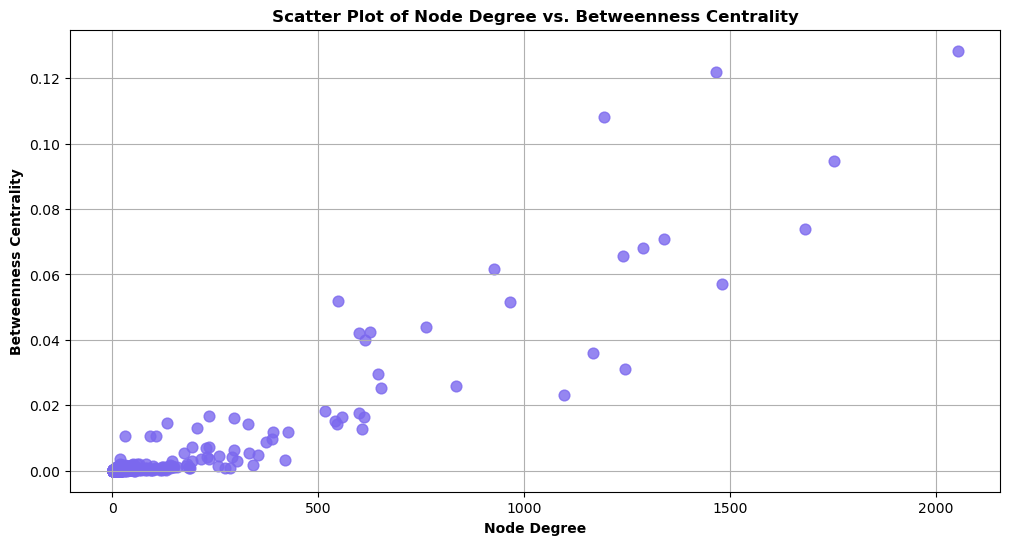

In [80]:
# Scatterplot of degree vs betweeness
x = measures_ppi['Degree']
y = measures_ppi['Betweeness']

plt.figure(figsize=(12, 6))
plt.scatter(x, y, color = 'mediumslateblue', alpha = 0.8, s = 60)

plt.title('Scatter Plot of Node Degree vs. Betweenness Centrality', fontweight='bold')
plt.xlabel('Node Degree', fontweight='bold')
plt.ylabel('Betweenness Centrality', fontweight='bold')
plt.grid()
plt.show()

In [82]:
# Average degree and degree distribution
print('\nAverage degree:', np.mean(sorted_metrics.Degree))
print('\n-----------------------')
fig = px.histogram(sorted_metrics.Degree,
                   nbins = len(sorted_metrics.Degree.unique()),
                   title = 'Degree distribution')
fig.update_layout(yaxis_type = 'log', xaxis_title = 'degree', yaxis_title = 'count', bargap = 0.2)
fig.update_traces(marker_color = 'mediumslateblue')
fig.show()


Average degree: 10.72510877911441

-----------------------


**(Da rivedere/sistemare/aggiungere)**

The degree distribution in the PPI network follows a **scale-free model**: some proteins acts like *hubs* with very high number of interactions, while the majority of proteins interact with only a few others.

### 1.3) Network visualization

In [ ]:
# Plot the PPI Largest Connected Component -> troppo grande?
pos = nx.spring_layout(LCC_ppi, seed=42)

plt.clf()
plt.figure(figsize = (14, 10))
nx.draw(LCC_ppi, pos, with_labels = True, node_color = 'violet', node_size = 1000,
        edge_color = 'gray', linewidths = 1, font_size = 16)

plt.title("PPI Largest connected Component Network", fontweight = 'bold')
plt.show()

In [ ]:
# CAREFUL
# Takes a while to plot
plt.figure(figsize = (9, 7))
nx.draw_spring(LCC_ppi, node_size = 30, arrows = False, node_color = 'mediumslateblue')
plt.title('Protein-Protein Interaction Network')
plt.show()

${TO-DO:}$ it still takes too much to run. Try to run it in Colab with the GPU.

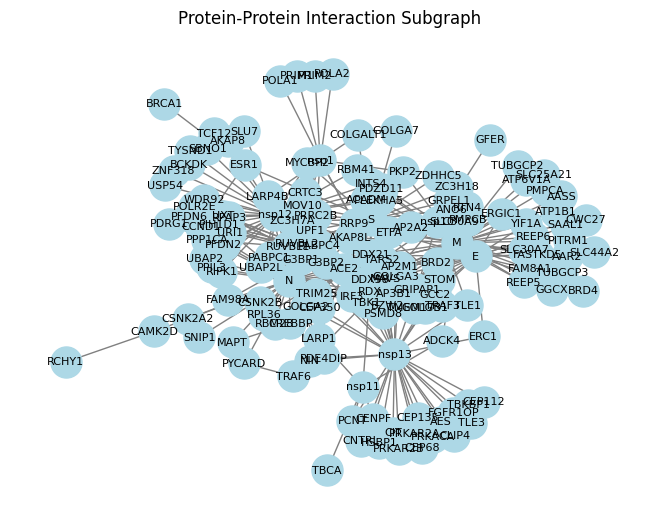

In [38]:
# Visualize only a subgraph of the network with fewer nodes for faster rendering
subgraph = LCC_ppi.subgraph(list(LCC_ppi.nodes)[:150])  # Take only a portion of the graph for visualization
pos = nx.spring_layout(subgraph, seed = 42)
nx.draw(subgraph, pos, with_labels = True, node_color ='lightblue', edge_color ='gray', node_size = 500, font_size = 8)

plt.title("Protein-Protein Interaction Subgraph")
plt.show()

## 2) Community detection

**(Da rivedere/sistemare/aggiungere)**

We experimented with clustering algorithms for community detection based on the **disease module hypothesis**. This hypothesis assumes that topological communities overlap with functional and disease modules and that the disease phenotype can be described by their breakdown.

In this context, we compared the outcomes of three algorithms that align with this assumption:

- **Kwik Cluster (or Pivot) Algorithm**
- **Markov Clustering (MCL) Algorithm**
- **Louvain Algorithm**

### Clustering Coefficient and Modularity

**(Da rivedere/sistemare/aggiungere)**

Proteins tend to form groups or modules, similar to how people in a social network form communities. Each module represents a set of related biological processes, as proteins involved in similar metabolic pathways are strongly interconnected.

In [36]:
clustering_coeff = nx.average_clustering(LCC_ppi)
print(f"PPI Network Clustering Coeffcient: {clustering_coeff}")

PPI Network Clustering Coeffcient: 0.05285528299003698


In protein-protein interaction (PPI) networks, it is common to observe relatively low global clustering coefficients. This is because protein interactions are often sparse, and not all proteins directly interact with each other.

### 2.1) KWIKCLUSTER (or PIVOT) Algorithm

**[Inserire commento introduttivo e/o pseudocodice]**

### 2.2) Markov Cluster Algorithm

The Markov Clustering (MCL) algorithm detects clusters by simulating **random flow** through a graph.  It essentially performs matrix multiplication on the adjacency matrix of the graph to propagate the flow between nodes.

In [214]:
# Convert the LCC_ppi network to a suitable format for MCL algorithm
matrix = nx.to_scipy_sparse_array(LCC_ppi)
matrix = csr_matrix(matrix)
matrix.shape

(8086, 8086)


The **inflation parameter** controls the granularity of clustering:

- Inflation > 1: increases the tendency to form smaller and more distinct clusters, resulting in a greater number of clusters.
- Inflation < 1: increases the tendency to form larger and more general clusters, resulsing in fewer clusters as the algorithm becomes less aggressive in clustering.

In [245]:
# Run the MCL algorithm with inflaction = 1.8
result = mc.run_mcl(matrix, inflation = 1.8)
clusters = mc.get_clusters(result)

In [246]:
#select communities with a number of nodes between 100 and 1000
MCL_clusters_filtered = [cluster for cluster in clusters if 300 <= len(cluster) <= 1000]
print("Number of filtered MCL clusters: ", len(MCL_clusters_filtered))

Number of filtered MCL clusters:  5


In [247]:
for i, cluster in enumerate(MCL_clusters_filtered):
  print(f"Number of proteins in MCL Cluster {i + 1}: {len(cluster)}")

Number of proteins in MCL Cluster 1: 569
Number of proteins in MCL Cluster 2: 336
Number of proteins in MCL Cluster 3: 557
Number of proteins in MCL Cluster 4: 354
Number of proteins in MCL Cluster 5: 318


In [248]:
nodes = np.array(LCC_ppi.nodes())
MCL_clusters_filtered_2 = []
for cluster in MCL_clusters_filtered:
  cluster_names = [nodes[index] for index in cluster]
  MCL_clusters_filtered_2.append(cluster_names)

In [249]:
# positions = nx.spring_layout(LCC_ppi)
# mc.draw_graph(matrix, clusters, pos = positions, node_size = 50, with_labels = False, edge_color = "silver")

### 2.3) Louvain Algorithm

Louvain algorithm optimizes modularity by iteratively merging nodes into communities to maximize the **modularity score**.

The **resolution parameter** adjusts the scale of the communities detected:

- By increasing the sensitivity to modularity variations, the algorithm tends to identify smaller and more numerous communities.

- By decreasing the sensitivity to modularity variations, the algorithm tends to identify larger and fewer communities.

In [263]:
# Run the Louvain algorithm with gamma = 1.3
louvain_communities = nx.community.louvain_communities(LCC_ppi, weight = 'weight', resolution = 1, seed = 42)

In [264]:
#select communities with a number of nodes between 300 and 1000 ?
louvain_communities_filtered = [community for community in louvain_communities if 300 <= len(community) <= 1000]
print("Number of filtered Louvain communities: ", len(louvain_communities_filtered))

Number of filtered Louvain communities:  5


In [265]:
for i, community in enumerate(louvain_communities_filtered):
  print(f"Number of proteins in Louvain Community {i + 1}: {len(community)}")

Number of proteins in Louvain Community 1: 512
Number of proteins in Louvain Community 2: 460
Number of proteins in Louvain Community 3: 656
Number of proteins in Louvain Community 4: 523
Number of proteins in Louvain Community 5: 845


### Comparison

**Rendendo i clusters per entrambi i due algoritmi molto specifici, riusciamo ad ottenere una sovrapposizione più "elevata" tra i cluster formati dai due algoritmi. Rimane da capire se va bene così o provare altre opzioni**

In [267]:
set(MCL_clusters_filtered_2[0]).intersection(louvain_communities_filtered[0])

{'AES',
 'AGO3',
 'CCAR1',
 'CCDC6',
 'CDC42EP3',
 'CDC5L',
 'CDK5RAP2',
 'CGN',
 'CTR9',
 'DHX16',
 'EPS15L1',
 'EYA3',
 'FGFR1OP',
 'FN3KRP',
 'FRG1',
 'GABPA',
 'HGH1',
 'IRS2',
 'KLF16',
 'LPIN1',
 'LSM14A',
 'MAP2K4',
 'MED8',
 'METAP2',
 'MRRF',
 'MVB12A',
 'NOL7',
 'NSFL1C',
 'NSRP1',
 'PDE4DIP',
 'PRPF4B',
 'PSRC1',
 'SRSF11',
 'THOC2',
 'THOC3',
 'TLE1',
 'WIPF2'}

In [293]:
print(len(set(MCL_clusters_filtered_2[4]).intersection(louvain_communities_filtered[1])))
print(len(set(MCL_clusters_filtered_2[2]).intersection(louvain_communities_filtered[2])))
print(len(set(MCL_clusters_filtered_2[1]).intersection(louvain_communities_filtered[3])))
print(len(set(MCL_clusters_filtered_2[3]).intersection(louvain_communities_filtered[4])))

12
338
192
12


## 3) Link Prediction with Graph Neural Networks (GNNs)

 ### 3.1) Exploring different models to perform the prediction task

 GAT, GCN, etc.

 Transformers?

### 3.2) Evaluation of results

(using metrics such as confusion matrix, accuracy, precision, recall, F1 score, hits@k, etc.)

## [Optional: Influence and Homophily?]

**[Spostare questa sezione subito dopo il Clustering]**

For any experiment in this area, we can take into consideration the Organism Interactor name as the "class" to which the proteins belong. Remember that in this dataset every row represent an interaction between two proteins, and we have both names of their organisms. We might need to build a new graph containing this information (the one we use for community detection just contains the protein names).

In [ ]:
# 1. [Indipendente dal clustering]
#    Visualizzare e commentare il numero di interazioni presenti nel dataset tra proteine
#    dello stesso organismo, ex: umano-umano, sars2-sars2, sars-sars, mers-mers
#    (NB: normalizziamo per numero di proteine per ogni organismo, perché per esempio le proteine umane sono
#     la categoria più presente)

# 2. [Dopo il clustering]
#    Visualizzare e commentare il numero di interazioni tra proteine dello stesso cluster,
#    che potrebbe indicare una tendenza a interagire tra proteine appartenenti allo stesso "processo biologico" (?) -> capire meglio che cos'è

## 4) Conclusions